In [27]:
from google.colab import drive
drive.mount('/content/drive')

# path for google drive
path = '/content/drive/My Drive/ECSE415/FinalProject/'
frame_path = '/content/drive/My Drive/ECSE415/FinalProject/frames/'
positive_path = '/content/drive/My Drive/ECSE415/FinalProject/positive/'
negative_path = '/content/drive/My Drive/ECSE415/FinalProject/negative/'
person_path = '/content/drive/My Drive/ECSE415/FinalProject/person/'
positive_test = '/content/drive/My Drive/ECSE415/FinalProject/positive_test/'
negative_test = '/content/drive/My Drive/ECSE415/FinalProject/negative_test/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
!pip install --upgrade imutils
# opencv is pre-installed on colab

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Requirement already up-to-date: imutils in /usr/local/lib/python3.6/dist-packages (0.5.3)


In [29]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [45]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from skimage.feature import hog

import time
import random as rg
import math
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import csv

# Image extraction from folders and creating image set

In [31]:
def CreateTrainSet(positive_path, negative_path, IMAGE_WIDTH, IMAGE_HEIGHT, Positive_Images=1200):
  # getting all file names from positive path
  positives = os.listdir(positive_path)
  positive_files = [os.path.join(positive_path, file_name) for file_name in positives if file_name.endswith('.jpg')]
  positive_files.sort()

  # getting all file names from negative path
  negatives = os.listdir(negative_path) 
  negative_files = [os.path.join(negative_path, file_name) for file_name in negatives if file_name.endswith('.jpg')]
  negative_files.sort()

  # creating train label np array for pos=0 and neg=1
  pos_labels = np.zeros(Positive_Images)
  neg_labels = np.ones(len(negative_files))
  train_labels = np.concatenate((pos_labels, neg_labels), axis=0).astype(int)
  
  # add positive images to train_image np array
  pos_images = np.zeros((Positive_Images, IMAGE_HEIGHT, IMAGE_WIDTH))
  for filename in positive_files[0: Positive_Images]:
    img = cv2.imread(filename, 0)
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    pos_images[positive_files.index(filename)] = img
  
  # add negative images to train_image np array
  neg_images = np.zeros((len(negative_files), IMAGE_HEIGHT, IMAGE_WIDTH))
  for filename in negative_files:
    img = cv2.imread(filename, 0)
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    neg_images[negative_files.index(filename)] = img
  
  train_images = np.zeros((len(positive_files)+len(negative_files), IMAGE_HEIGHT, IMAGE_WIDTH))
  train_images = np.concatenate((pos_images, neg_images), axis=0).astype(int)
  return train_images, train_labels

In [32]:
Positive_Images = 1200
print(f"Path exists: {os.path.isdir(positive_path) and os.path.isdir(negative_path)}")
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 128
R_train_images, train_labels = CreateTrainSet(positive_path, negative_path, IMAGE_WIDTH, IMAGE_HEIGHT, Positive_Images)

print("train_images: ", R_train_images.shape)
print("train_labels: ", train_labels.shape)
print(R_train_images[0])
print(train_labels[0])
print(R_train_images[-1])
print(train_labels[-1])

Path exists: True
train_images:  (1480, 128, 64)
train_labels:  (1480,)
[[196 197 201 ... 124 119 117]
 [195 197 200 ... 125 118 115]
 [195 196 200 ... 126 116 111]
 ...
 [181 181 181 ... 182 181 181]
 [178 178 177 ... 184 184 184]
 [176 176 175 ... 186 186 186]]
0
[[198 198 197 ... 123 113 106]
 [196 196 196 ... 121 115 113]
 [194 194 194 ... 121 123 128]
 ...
 [247 247 246 ... 246 245 245]
 [250 250 248 ... 244 244 244]
 [247 247 246 ... 246 247 247]]
1


# Getting Hog features and creating training feature set

In [33]:
# returns HoG features, and orderd features
def HoG_features(images):
    cell_size = (8,8)
    block_size = (4,4)
    nbins = 4

    # all images have same shape
    img_size = images[0].shape

    # creating HoG object
    hog = cv2.HOGDescriptor(_winSize=(img_size[1] // cell_size[1] * cell_size[1],
                                    img_size[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

    features = []
    for i in range(images.shape[0]):
        
        # Compute HoG features
        features.append(hog.compute((images[i]).astype(np.uint8)).reshape(1, -1))
    
    # Stack arrays in sequence vertically 
    features = np.vstack(features)
   
    return features

In [34]:
# getting HoG features
train_features = HoG_features(R_train_images)
print("trained_features_reshaped: ", train_features.shape)
print("trained_features_reshaped[0]: ", train_features[0])

trained_features_reshaped:  (1480, 4160)
trained_features_reshaped[0]:  [0.03915166 0.0065741  0.00676362 ... 0.0232183  0.02239115 0.00087363]


# Non-linear SVM Classifier

In [105]:
def NonLinear_SVM(train_features, train_labels, gamma, C, random_state=None):
    # creating non-linear svc object, RBF kernel is default
    clf = svm.SVC(C=C, gamma=gamma, random_state=random_state)

    # fit and predict
    clf.fit(train_features, train_labels)
    return clf

def predict(clf, test_features, test_labels):
    predict = clf.predict(test_features)
    
    # using accruacy score from metrics lib and multiply 100 to get precentage
    accuracy = accuracy_score(test_labels, predict)*100
    return accuracy

# 1 Fold Validation

In [37]:
k_fold = 5
pos_count = Positive_Images
neg_count = 280
pos_train_split = int(pos_count*4/k_fold)
neg_train_split = int(pos_count+neg_count*4/k_fold)

print(f"train_size: {pos_train_split+neg_train_split-pos_count}")
print(f"test_size: {pos_count-pos_train_split+neg_count-neg_train_split+pos_count}")

# splitting all pos and neg into 4/5 for train and 1/5 split for test
train_features_split = np.concatenate((train_features[: pos_train_split],  train_features[pos_count: neg_train_split]), axis=0)
train_labels_split = np.concatenate((train_labels[: pos_train_split], train_labels[pos_count: neg_train_split]), axis=0)

val_features_split = np.concatenate((train_features[pos_train_split:pos_count],  train_features[neg_train_split:]), axis=0)
val_labels_split = np.concatenate((train_labels[pos_train_split:pos_count],  train_labels[neg_train_split:]), axis=0)

print(f"train_split: {train_features_split.shape} and {train_labels_split.shape}")
print(f"val_split: {val_features_split.shape} and {val_labels_split.shape}")

train_size: 1184
test_size: 296
train_split: (1184, 4160) and (1184,)
val_split: (296, 4160) and (296,)


In [ ]:
MIN_ACCURACY = 50
GammaList = ['auto', 'scale']
C_List = [0.01, 0.1, 1, 10, 100, 1000]
Best_SVM = {"gamma":None, "C":None, "accuracy":0}
for gamma in GammaList:
    for C in C_List:
        clf = NonLinear_SVM(train_features_split, train_labels_split, gamma, C)
        accuracy = predict(clf, val_features_split, val_labels_split)
        if round(accuracy, 2) > MIN_ACCURACY:
            print(f"Gamma: {gamma}, C: {C},  Accuracy: {round(accuracy, 2)}%")
        if round(accuracy, 2) > Best_SVM["accuracy"]:
            Best_SVM["gamma"] = gamma
            Best_SVM["C"] = C
            Best_SVM["accuracy"] = round(accuracy, 2)
print("Best parameters: ", Best_SVM)

# 5 Fold Cross Validation

In [ ]:
def k_fold_SVC(train_features, train_labels, train_index, val_index, k_folds):
    total_accuracy = 0
    for i in range(k_folds):
        x_train, x_val = train_features[train_index], train_features[val_index]
        y_train, y_val = train_labels[train_index], train_labels[val_index]
        clf = NonLinear_SVM(x_train, y_train, gamma, C)
        total_accuracy += predict(clf, x_val, y_val)
    avg_accuracy = total_accuracy/k_folds
    return avg_accuracy

In [ ]:
# 5 fold cross validation dataset
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)
kf.get_n_splits(train_features)

MIN_ACCURACY = 50
GammaList = ['auto', 'scale']
C_List = [0.01, 0.1, 1, 10, 100, 1000]
Best_SVM = {"gamma":None, "C":None, "accuracy":0}
for gamma in GammaList:
    for C in C_List:
        start_time = time.time()
        for train_index, val_index in kf.split(train_features):
            accuracy = k_fold_SVC(train_features, train_labels, train_index, val_index, 5)
        time_taken = (time.time() - (start_time))/k_folds
        if round(accuracy, 2) > MIN_ACCURACY:
            print(f"Gamma: {gamma}, C: {C},  Accuracy: {round(accuracy, 2)}%, time taken to train/test: {round(time_taken, 2)}")
        if round(accuracy, 2) > Best_SVM["accuracy"]:
            Best_SVM["gamma"] = gamma
            Best_SVM["C"] = C
            Best_SVM["accuracy"] = round(accuracy, 2)
print("Best parameters: ", Best_SVM)

# Using Optimal Paramaeters for SVM Classifier

In [106]:
# Optimal SVM Classifer
gamma = "scale"
C = 10
Optimal_Clf = NonLinear_SVM(train_features_split, train_labels_split, gamma, C)
accuracy = predict(clf, val_features_split, val_labels_split)
print(f"Gamma: {gamma}, C: {C},  Accuracy: {round(accuracy, 2)}%")

Gamma: scale, C: 10,  Accuracy: 96.62%


# Comparison with detectron

In [54]:
def load_images(image_path):
  files = os.listdir(frame_path) 
  files_name = [file_name for file_name in files if file_name.endswith('.jpg')]
  files_name.sort()
  frames = []

  #read the first 100 images
  for i, file_name in enumerate(files_name):
    frame = cv2.imread(image_path + file_name)
    frames.append(frame)

  frames = np.array(frames)
  return frames
seq_images = load_images(frame_path)

In [40]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_280758.pkl: 167MB [00:02, 67.8MB/s]                           


In [63]:
# crop positive samples
def crop_objects(img, outputs, image_index, writer):
  classes = outputs["instances"].pred_classes
  boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
  #create dictionary to hold count of objects for image name
  index = -1
  count = 0
  print()
  test_images = []
  test_labels = []
  for class_index in classes:
    # get count of class for part of image name
    # class_index = int(classes[i])
    if class_index == 0:
      # get box coords
      box = boxes[index]
      # print(box)
      xmin, ymin, xmax, ymax = box
      # crop detection from image (take an additional 5 pixels around all edges)
      cropped_img = img[int(ymin):int(ymax), int(xmin):int(xmax)]

      test_images.append(cropped_img)
      test_labels.append(0)
      count+=1
  writer.writerow([image_index+1, count])
  return writer, test_images, test_labels

In [85]:
# returns an array of resized images and converts to grayscale
def ResizeImages(images, IMAGE_WIDTH, IMAGE_HEIGHT):
    ResizedImages = np.zeros((len(images), IMAGE_HEIGHT, IMAGE_WIDTH))
    for i in range(len(images)):
      img = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
      ResizedImages[i] = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    return ResizedImages

In [108]:
def comparative_acc(Optimal_Clf, test_images, test_labels):
    # resize and grayscale for HoG
    R_test_images = ResizeImages(test_images, IMAGE_WIDTH, IMAGE_HEIGHT)
    # print("R_train_images: ", R_train_images.shape)

    # create HoG test features
    test_features = HoG_features(R_test_images)
    # print("trained_features_reshaped: ", test_features.shape)
    # print("trained_features_reshaped[0]: ", test_features[0])

    # accuracy
    accuracy = predict(Optimal_Clf, test_features, test_labels)
    # print(f"Gamma: {gamma}, C: {C},  Accuracy: {round(accuracy, 2)}%")
    return accuracy

1




















































































































































































































































































































































































































































































































1


















































































































































































































































































































































































































































































































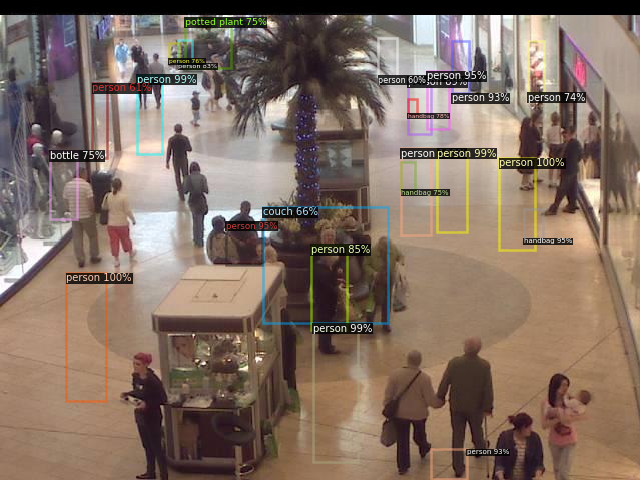

In [117]:
cfile = open(path + 'detectron_count.csv', 'w+', newline='')
accfile = open(path + 'accuracy_comparison.csv', 'w+', newline='')
writer = csv.writer(cfile)
writer.writerow(["id", "Count"])
acc_writer = csv.writer(accfile)
acc_writer.writerow(["id", "accuracy"])

# getting HoG features
IMAGE_WIDTH = 64    # same as train image
IMAGE_HEIGHT = 128

# use optimal parameter for model
gamma = "scale"
C = 10

test_img_set = []
for image_index in range(len(seq_images)):
  try:
    outputs = predictor(seq_images[image_index])
    writer, test_images, test_labels = crop_objects(seq_images[image_index], outputs, image_index, writer)
    accuracy = comparative_acc(Optimal_Clf, test_images, test_labels)
    acc_writer.writerow([image_index+1, accuracy])
  except Exception as e:
    print(str(e))

cfile.close
accfile.close

v = Visualizer(seq_images[0][:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
import imutils
def pyramid(image, scale=1.5, minSize=(30, 30)):
	# yield the original image
	yield image
	# keep looping over the pyramid
	while True:
		# compute the new dimensions of the image and resize it
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		# yield the next image in the pyramid
		yield image

def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

def detectron_detect(img):
  frame = np.array(img)
  outputs = predictor(frame)
  v = Visualizer(frame[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])
  classes = outputs["instances"].pred_classes
  boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
  #create dictionary to hold count of objects for image name
  index = -1
  count = 0
  for class_index in classes:
    index+=1
    if class_index == 0:
      # get box coords
      box = boxes[index]
  return class_index, box

(winW, winH) = (64, 128)
def window_predict(clf, image):
  person_count = 0
  # loop over the image pyramid
  for resized in pyramid(image, scale=1.5):
    # loop over the sliding window for each layer of the pyramid
    for (x, y, window) in sliding_window(resized, stepSize=32, windowSize=(winW, winH)):
      # if the window does not meet our desired window size, ignore it
      if window.shape[0] != winH or window.shape[1] != winW:
        # detectron predict
        det_label, det_box = detectron_detect(window))
        
        # svm prediction
        # test feature: window
        SVM_prediction = clf.predict(window)
        # both predict true
        if SVM_prediction == 1 and det_label == 0:
          person_count += 1
          SumIOU += bb_intersection_over_union(window, det_box)
        # SVM predicts true || False Positive
        elif SVM_prediction == 1:
          SumIOU += 0
          person_count += 1
        # detectron predicts true || False Negative
        elif det_label == 0:
          SumIOU += 0
          person_count += 1

        # since we do not have a classifier, we'll just draw the window
        clone = resized.copy()
        cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
        # cv2_imshow("Window", clone)
        # cv2.waitKey(1)
        # time.sleep(0.025)
  AvgIOU = SumIOU / person_count 
  return AvgIOU

In [ ]:
def bb_intersection_over_union(BoxA, BoxB):
  A_xmin, A_ymin, A_xmax, A_ymax = BoxA
  B_xmin, B_ymin, B_xmax, B_ymax = BoxB

  # determine the (x, y)-coordinates of the intersection rectangle
  xA = max(A_xmin, B_xmin)
  yA = max(A_ymin, B_ymin)
  xB = min(A_xmax, B_xmax)
  yB = min(A_ymax, B_ymax)
  # compute the area of intersection rectangle
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)
  # return the intersection over union value
  return iou

In [ ]:
def LBP(images, radius):
    P = 8 * radius
    R = radius
    features = []
    eps = 1e-7
    for img in images:
        lbp = feature.local_binary_pattern(img, P, R)
        (hist, _) = np.histogram(lbp.ravel(),bins=np.arange(0, P + 3),range=(0, P + 2))
        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        if np.isnan(hist.any()):
            print("nan")
        
        features.append(hist)
    features=np.array(features)
    return features